In [1]:
# common params
IMAGE_SIZE = 448
BATCH_SIZE = 8
NUM_CLASSES = 20
MAX_OBJECTS_PER_IMAGE = 20

# dataset params
DATA_PATH = './pascal_voc_training_data.txt'
IMAGE_DIR = './VOCdevkit_train/VOC2007/JPEGImages/'
import numpy as np
import tensorflow as tf

# 圖片平移函數測試

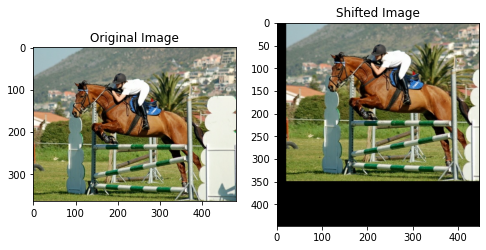

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt

def translate_image(image, tx, ty):
    """平移影像
    Args:
        image: 輸入影像 (3D Tensor)。
        tx: 水平平移量（正數向右，負數向左）。
        ty: 垂直平移量（正數向下，負數向上）。
    Returns:
        平移後的影像。
    """
    # 建立平移矩陣
    transform = [1, 0, -tx, 0, 1, -ty, 0, 0]  # 平移矩陣
    image = tf.expand_dims(image, axis=0)    # 增加 batch 維度
    output = tf.raw_ops.ImageProjectiveTransformV3(
        images=image,
        transforms=[transform],
        #output_shape=image.shape[1:3],
        output_shape=(IMAGE_SIZE,IMAGE_SIZE),
        interpolation="BILINEAR",
        fill_value=0
    )
    return tf.squeeze(output, axis=0)  # 去除 batch 維度

# 測試影像
image_file = tf.io.read_file(IMAGE_DIR+"000017.jpg")
image = tf.io.decode_jpeg(image_file, channels=3)

# 指定平移量
shifted_image = translate_image(image, tx=20.3, ty=-15)

# 視覺化結果
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.title("Shifted Image")
plt.imshow(shifted_image)
plt.show()


# tf.image.central_crop測試

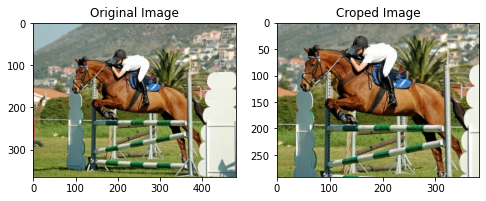

(364, 480, 3) (292, 384, 3)


In [3]:
# 測試影像
image_file = tf.io.read_file(IMAGE_DIR+"000017.jpg")
image = tf.io.decode_jpeg(image_file, channels=3)

# 指定平移量
croped_image = tf.image.central_crop(image, 0.8)

# 視覺化結果
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.title("Croped Image")
plt.imshow(croped_image)
plt.show()
print(image.shape,croped_image.shape)

# 主要程式 我完全沒有動_data_preprocess以外的部分\\
# 請注意不要直接複製這裡的code,因為我有額外加測試用的回傳值
# 這份.ipynb僅供測試
# 請去複製Data Augmentation.ipynb的code

In [4]:
class DatasetGenerator:
    """
    Load pascalVOC 2007 dataset and creates an input pipeline.
    - Reshapes images into 448 x 448
    - converts [0 1] to [-1 1]
    - shuffles the input
    - builds batches
    """

    def __init__(self):
        self.image_names = []
        self.record_list = []
        self.object_num_list = []
        # filling the record_list
        input_file = open(DATA_PATH, 'r')

        for line in input_file:
            line = line.strip()
            ss = line.split(' ')
            self.image_names.append(ss[0])

            self.record_list.append([float(num) for num in ss[1:]])

            self.object_num_list.append(min(len(self.record_list[-1])//5,
                                            MAX_OBJECTS_PER_IMAGE))
            if len(self.record_list[-1]) < MAX_OBJECTS_PER_IMAGE*5:
                # if there are objects less than MAX_OBJECTS_PER_IMAGE, pad the list
                self.record_list[-1] = self.record_list[-1] +\
                [0., 0., 0., 0., 0.]*\
                (MAX_OBJECTS_PER_IMAGE-len(self.record_list[-1])//5)

            elif len(self.record_list[-1]) > MAX_OBJECTS_PER_IMAGE*5:
               # if there are objects more than MAX_OBJECTS_PER_IMAGE, crop the list
                self.record_list[-1] = self.record_list[-1][:MAX_OBJECTS_PER_IMAGE*5]

    def _data_preprocess(self, image_name,raw_labels, object_num):
        image_file = tf.io.read_file(IMAGE_DIR+image_name)
        image = tf.io.decode_jpeg(image_file, channels=3)
        
        # Apply data augmentation and record transformations
        
        # flip_horizontal: boolean value of whether flip horizontal
        # dx: translation precentage of image on x axis ex. 0.05=>move right 0.05*IMAGE_SIZE pixels
        # dy: similar on y axis
        # crop_scale: central crop scale in 0.8~1.0
        
        flip_horizontal = tf.cast(tf.random.uniform([], 0, 2, dtype=tf.int32), tf.bool)
        dx = np.random.uniform(-0.1, 0.1)
        dy = np.random.uniform(-0.1, 0.1)
        crop_scale = tf.random.uniform([], 0.8, 1.0)
        
        # 1. Flip horizontal
        w_flip = tf.cast(tf.shape(image)[1], tf.float32)
        image = tf.cond(flip_horizontal, 
                       lambda: tf.image.flip_left_right(image),
                       lambda: image)
        # 2. Shift
        def translate_image(image, tx, ty):
            """平移影像
            Args:
                image: 輸入影像 (3D Tensor)。
                tx: 水平平移量（正數向右，負數向左）。
                ty: 垂直平移量（正數向下，負數向上）。
            Returns:
                平移後的影像。
            """
            # 建立平移矩陣
            transform = [1, 0, -tx, 0, 1, -ty, 0, 0]  # 平移矩陣
            image = tf.expand_dims(image, axis=0)    # 增加 batch 維度
            output = tf.raw_ops.ImageProjectiveTransformV3(
                images=image,
                transforms=[transform],
                #output_shape=image.shape[1:3],
                output_shape=(IMAGE_SIZE,IMAGE_SIZE),
                interpolation="BILINEAR",
                fill_value=0
            )
            return tf.squeeze(output, axis=0)  # 去除 batch 維度
        image = translate_image(image, dx * IMAGE_SIZE, dy * IMAGE_SIZE)
        # 3. Central crop
        h = tf.cast(tf.shape(image)[0], tf.float32)
        w = tf.cast(tf.shape(image)[1], tf.float32)
        image = tf.image.central_crop(image, crop_scale)
        # 4. Brightness, Contrast, Gaussian noise
        image = tf.image.random_brightness(image, 0.2)
        image = tf.image.random_contrast(image, 0.8, 1.2)
        image = tf.cast(image, tf.float32)  # Ensure image is float32 for arithmetic operations
        image = image + tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.1, dtype=tf.float32)
        image = tf.clip_by_value(image, 0.0, 255.0)  # Keep the pixel values in the valid range
        image = tf.cast(image, tf.uint8)  # Convert back to uint8 if necessary

        h_after = tf.shape(image)[0]
        w_after = tf.shape(image)[1]
        width_ratio  = IMAGE_SIZE * 1.0 / tf.cast(w_after, tf.float32)
        height_ratio = IMAGE_SIZE * 1.0 / tf.cast(h_after, tf.float32)
        # 5. Resize
        image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = (image/255) * 2 - 1

        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)

        # Modify labels to correctly record bounding box
        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]
        # 1. Flip
        xmin_new = tf.cond(flip_horizontal, lambda: w_flip - xmin, lambda: xmin)
        xmax_new = tf.cond(flip_horizontal, lambda: w_flip - xmax, lambda: xmax)
        xmin=tf.where(xmin_new>xmax_new,xmax_new, xmin_new)
        xmax=tf.where(xmin_new>xmax_new, xmin_new, xmax_new)

        # 2. Shift
        xmin = (xmin + dx * IMAGE_SIZE)
        xmax = (xmax + dx * IMAGE_SIZE)
        ymin = (ymin + dy * IMAGE_SIZE)
        ymax = (ymax + dy * IMAGE_SIZE)
        
        # 3. Central crop
        xmin = xmin - w*(1-crop_scale)/2
        xmax = xmax - w*(1-crop_scale)/2
        ymin = ymin - h*(1-crop_scale)/2
        ymax = ymax - h*(1-crop_scale)/2
        
        # 4. Brightness, Contrast, Gaussian noise
        # 5. Resize
        xmin = xmin * width_ratio
        ymin = ymin * height_ratio
        xmax = xmax * width_ratio
        ymax = ymax * height_ratio
        
        # move the values into range (0~IMAGE_SIZE) if possible
        xmin=tf.where(xmin>=0,xmin,0.)
        xmax=tf.where(xmax<IMAGE_SIZE,xmax,IMAGE_SIZE*1.0)
        ymin=tf.where(ymin>=0,ymin,0.)
        ymax=tf.where(ymax<IMAGE_SIZE,ymax,IMAGE_SIZE*1.0)
        # If any value is out of range, set as a padding box
        range_mask=tf.range(raw_labels.shape[0],dtype=tf.int32) < int(object_num)
        edge_mask = tf.logical_and(xmin < xmax, ymin < ymax)
        valid_mask = tf.logical_and(range_mask,edge_mask)

        # Get indices of valid objects
        valid_indices = tf.where(valid_mask)[:, 0]

        # Update object_num to reflect the number of valid objects
        object_num = tf.shape(valid_indices)[0]

        # Select valid values for xmin, xmax, ymin, ymax
        xmin_valid = tf.gather(xmin, valid_indices)
        xmax_valid = tf.gather(xmax, valid_indices)
        ymin_valid = tf.gather(ymin, valid_indices)
        ymax_valid = tf.gather(ymax, valid_indices)

        # Pad the valid tensors to match MAX_OBJECTS_PER_IMAGE
        padding_size = MAX_OBJECTS_PER_IMAGE - tf.shape(valid_indices)[0]
        xmin_padded = tf.concat([xmin_valid, tf.zeros([padding_size], dtype=tf.float32)], axis=0)
        xmax_padded = tf.concat([xmax_valid, tf.zeros([padding_size], dtype=tf.float32)], axis=0)
        ymin_padded = tf.concat([ymin_valid, tf.zeros([padding_size], dtype=tf.float32)], axis=0)
        ymax_padded = tf.concat([ymax_valid, tf.zeros([padding_size], dtype=tf.float32)], axis=0)

        # Compute xcenter, ycenter, box_w, and box_h
        xcenter = (xmin_padded + xmax_padded) / 2.0
        ycenter = (ymin_padded + ymax_padded) / 2.0
        box_w = tf.math.abs(xmax_padded - xmin_padded)
        box_h = tf.math.abs(ymax_padded - ymin_padded)

        # Create the skip mask
        skip_mask = tf.range(MAX_OBJECTS_PER_IMAGE) < object_num

        # Create padding box and combine labels
        padding_box = tf.zeros([5], dtype=tf.float32)
        labels = tf.where(
            tf.expand_dims(skip_mask, axis=1),
            tf.stack([xcenter, ycenter, box_w, box_h, class_num[:MAX_OBJECTS_PER_IMAGE]], axis=1),
            tf.expand_dims(padding_box, axis=0)
        )
        
        return image, labels, tf.cast(object_num, tf.int32),image_name,raw_labels

    def generate(self):
        dataset = tf.data.Dataset.from_tensor_slices((self.image_names,
                                                      np.array(self.record_list),
                                                      np.array(self.object_num_list)))
        dataset = dataset.shuffle(100000)
        dataset = dataset.map(self._data_preprocess,
                              num_parallel_calls = tf.data.experimental.AUTOTUNE)
        dataset = dataset.batch(BATCH_SIZE)
        dataset = dataset.prefetch(buffer_size=200)

        return dataset

In [5]:
dataset=DatasetGenerator().generate()

In [6]:
classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle",
                 "bus", "car", "cat", "chair", "cow", "diningtable",
                 "dog", "horse", "motorbike", "person", "pottedplant",
                 "sheep", "sofa", "train","tvmonitor"]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


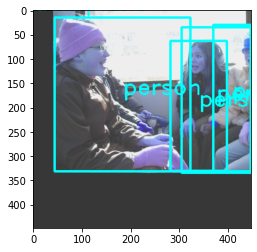

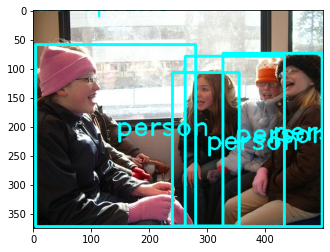

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
TEST_ID=2
for idx,(batch_image, batch_labels,batch_class_num,batch_image_name,batch_raw_labels) in enumerate(dataset):
    # print test
    image=batch_image[TEST_ID].numpy()
    labels=batch_labels[TEST_ID]
    class_num=batch_class_num[TEST_ID]
    image_name=batch_image_name[TEST_ID]
    raw_labels=batch_raw_labels[TEST_ID]
    np_img = (cv2.cvtColor(image, cv2.COLOR_BGR2RGB)+1)/2
    np_labels=batch_labels[TEST_ID].numpy()
    for i in range(MAX_OBJECTS_PER_IMAGE):
        #if i < class_num:
        #    print(np_labels[i])
        xcenter, ycenter, box_w, box_h, class_id = np_labels[i][0],np_labels[i][1],np_labels[i][2],np_labels[i][3],np_labels[i][4]
        #print(xcenter, ycenter, box_w, box_h, class_id)
        class_name = classes_name[int(class_id)]
        cv2.rectangle(np_img, (int(xcenter-box_w/2), int(ycenter-box_h/2)), (int(xcenter+box_w/2),\
                                                                             int(ycenter+box_h/2)), (0, 255, 255), 3)
        #print((int(xcenter-box_w/2), int(ycenter-box_h/2)),(int(xcenter+box_w/2), int(ycenter+box_h/2)))
        cv2.putText(np_img, class_name, (xcenter,ycenter), 2, 1.5, (0, 255, 255), 2)

    plt.imshow(np_img)
    plt.show()
    image_file = tf.io.read_file(IMAGE_DIR+image_name)
    image2 = tf.io.decode_jpeg(image_file, channels=3).numpy()
    for i in range(MAX_OBJECTS_PER_IMAGE):
        #print(raw_labels[i])
        xmin, ymin, xmax, ymax, class_id =raw_labels[i]
        class_name = classes_name[int(class_id)]
        cv2.rectangle(image2, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 255), 3)
        cv2.putText(image2, class_name, ((xmin+xmax)/2, (ymin+ymax)/2), 2, 1.5, (0, 255, 255), 2)
    plt.imshow(image2)
    plt.show()
    break